### Goal
Implement an autoencoder for dimensionality reduction. 

### TODO
 - 1.1 Find the number of PCA components which explain the variance of the data for at least 98% (for individual effect and gene effect)
 - 1.2 Recovery performance for the individual/gene effect models
 - 1.3 Retrain the coordinative fitting model using for P and Q the number of components that explains at least 98% of variance
 - 2.1 Implement Autoencoders using Keras and compare to the PCA for the dimensionality reduction of gene expression in blood (P-matrix individual effect)
 - 2.2 Summary models
 - 2.3 Blood autoencoder analysis


    

### Conclusions
 - 1.1
     - To explain 98\% of the variance between individuals the PCA needs at least 95 components.  
     - To explain 98\% of the genes variation across samples, the PCA needs at least 26 components.
 - 1.2 Median Spearmanr correlation = 0.93 / Mean Spearmanr correlation = 0.78 (n_comp = 95)
 - 1.3 Results did not improve
 - 2.1 

## 1.1 Analysis of PCA representing the individual and gene effect

In [50]:
import os

from joblib import dump, load
import numpy as np
import pandas as pd
import comet_ml

from rep import models as m
from rep import metrics as mt
from rep import constants as cst
from rep import linear_regression as lr
from rep import preprocessing_new as prep

from sklearn import metrics
from sklearn import decomposition
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from plotnine import *

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [51]:
import keras
from keras.layers import Input, Dense, Add, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, Adamax, Nadam
from keras.losses import *
from keras import regularizers
from keras.callbacks import EarlyStopping, ProgbarLogger, ReduceLROnPlateau, Callback

from numpy.random import seed
seed(1)

In [52]:
# data
(y_blood_train, y_muscle_train, meta_train, P_train, Q, n_genes_train, n_indiv_train), (y_blood_valid, y_muscle_valid, meta_valid, P_valid, Q, n_genes_valid, n_indiv_valid) = lr.prepare_linear_regression_input('Muscle - Skeletal')

(331, 19932)


## 1.2 Find the number of PCA components which explain the variance of the data for at least 98% (for individual effect and gene effect)
For the coordinative fitting model we used two PCAs, one to represent the individual effect and one for the gene effect. Until now we run the PCA using 10 components.<br/> In order to optimize this model we determine here which are the minimal number of components such that the PCA explains 98% of the data variance.

In [14]:
import math

def compute_pca_explained_variance(input_pca, n_comp):
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(input_pca)
    pca_transformed = pca.transform(input_pca)
    return np.cumsum(pca.explained_variance_ratio_)

def find_minimal_comp(input_gtex, left, right, cutoff=0.98):

    found = False
    if left <= right:
        middle = int(math.floor((left + right)/2))
            
        explained_variance = compute_pca_explained_variance(input_gtex, middle)
        if explained_variance[-1] >= cutoff: 
            found = True
        
        if left == right:
            return middle
        
        if found == True:
            return find_minimal_comp(input_gtex, left-1, middle, cutoff=0.98)
        else:
            return find_minimal_comp(input_gtex, middle+1, right, cutoff=0.98)
    return -1
        

In [15]:
path = "/s/project/rep/"
# path = "/home/mada/Uni/Masterthesis/online_repo/rep/data/"

train_individuals_file = path + "processed/gtex/recount/train_individuals.txt"
train_individuals = prep.read_csv_one_column(train_individuals_file)

<br/>

<b>(a) Individual effect</b> 

In [21]:
n_min_comp = find_minimal_comp(y_blood_train, 1, y_blood_train.shape[0])
n_min_comp

96

Text(0, 0.5, 'Cummulative explained variance')

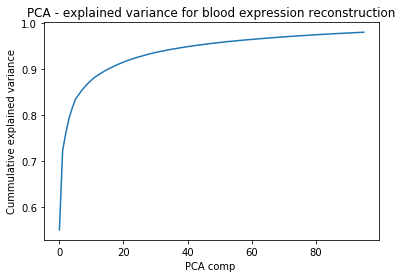

In [22]:
pca = decomposition.PCA(n_components=n_min_comp)
pca.fit(y_blood_train)
pca_transformed = pca.transform(y_blood_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA - explained variance for blood expression reconstruction")
plt.xlabel("PCA comp ")
plt.ylabel("Cummulative explained variance")

In [24]:
import pickle
pickle.dump(pca_transformed, open('/s/project/rep/processed/models/pca/individual_effect_pca95.pkl', "wb"))

<br/>

<b>(b) Gene effect<b/>

In [25]:
features_file = path + "processed/gtex/recount/recount_gtex_norm_tmp.h5ad"
train_individuals_file = path + "processed/gtex/recount/train_individuals.txt"
train_individuals = prep.read_csv_one_column(train_individuals_file)
gtex_raw = prep.RepAnnData.read_h5ad(features_file)
gtex_raw_train = gtex_raw[gtex_raw.samples['Individual'].isin(train_individuals)]

In [26]:
n_min_comp = find_minimal_comp(np.array(gtex_raw_train.X.T), 1, gtex_raw_train.X.T.shape[1])
n_min_comp

26

Text(0, 0.5, 'Cummulative explained variance')

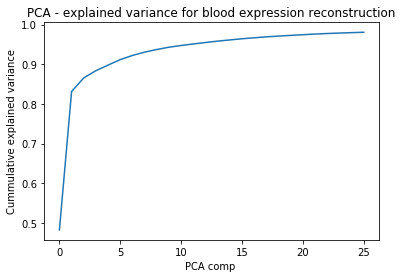

In [27]:
pca = decomposition.PCA(n_components=n_min_comp)
pca.fit(gtex_raw_train.X.T)
pca_transformed = pca.transform(gtex_raw_train.X.T)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA - explained variance for blood expression reconstruction")
plt.xlabel("PCA comp ")
plt.ylabel("Cummulative explained variance")

In [28]:
import pickle
pickle.dump(pca_transformed, open('/s/project/rep/processed/models/pca/gene_effect_pca26.pkl', "wb"))

### Recovery performance for the individual/gene effect

Evaluate performance of the PCA to recover data.

Inverse PCA: $PCA\_reconstruction=PC\_scores * Eigenvectors^⊤+mean$

In [56]:
def data_recovery(pca_model, X_):
    mu = np.mean(X_, axis=0)
    Xhat = np.dot(pca_model.transform(X_)[:,:nComp], pca_model.components_[:nComp,:])
    Xhat += mu
    
    return Xhat

#### Evaluate how much from the input data can be recovered using only the PCA 
<b>(a) Individual effect</b>

In [57]:
nComp = 95
pca = decomposition.PCA(n_components=nComp)
pca.fit(y_blood_train)

y_train_pred = data_recovery(pca, y_blood_train)
y_valid_pred = data_recovery(pca, y_blood_valid)

In [58]:
# evaluate - train set
ev = mt.rep_metric(y_blood_train, y_train_pred)
eval_metrics_pca = ev
ev['spearmanr']

{'mean': 0.8855184655770291,
 'min': 0.0,
 'p10': 0.6053831075863305,
 'p25': 0.8502390728594538,
 'median': 0.9781945999751152,
 'p75': 0.9930859951296682,
 'p90': 0.9959897971880056,
 'max': 0.9989886062674418}

In [44]:
# evaluate - validation set
ev = mt.rep_metric(y_blood_valid, y_valid_pred)
ev['spearmanr']

{'mean': 0.7859494877155191,
 'min': -0.2925734835684534,
 'p10': 0.27253274146503753,
 'p25': 0.7049911424497018,
 'median': 0.9380377637911883,
 'p75': 0.9763939281747499,
 'p90': 0.9856349500185115,
 'max': 0.995557201036653}

<b>(b) Gene effect</b>

In [47]:
nComp = 26
pca = decomposition.PCA(n_components=nComp)
pca.fit(np.array(gtex_raw_train.X.T))

y_train_pred = data_recovery(pca, np.array(gtex_raw_train.X.T))
ev = mt.rep_metric(np.array(gtex_raw_train.X.T), y_train_pred)
ev['spearmanr']

{'mean': 0.870248628002595,
 'min': -0.08663814567178,
 'p10': 0.7884666980670112,
 'p25': 0.8459173863754611,
 'median': 0.8924641204056464,
 'p75': 0.9205847782103848,
 'p90': 0.9348172570669375,
 'max': 0.9723993974040464}

## 1.3 Retrain the coordinative fitting model using for P and Q the number of components that explains at least 98% of variance

In [ ]:
from joblib import dump, load
import numpy as np
import pandas as pd

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

import pickle
from IPython.display import display, HTML

path_models = "/s/project/rep/processed/models/linear_regression/"
models = {
          'model4 + ridge_regression (n_comp_Q=10, n_comp_P=10)':f'{path_models}evaluation_tissues_model4_Q_tpm.json',
          'model4 + ridge_regression (n_comp_Q=26, n_comp_P=95)':f'{path_models}evaluation_tissues_model4_optimal.json',
          'model4 + huber_regression (n_comp_Q=10, n_comp_P=10)':f'{path_models}evaluation_tissues_huber_regression_Q_tmp.json',
          'model4 + huber_regression (n_comp_Q=26, n_comp_P=95)':f'{path_models}evaluation_tissues_huber_regression_optimal.json',
dict_evaluation = pickle.load(open(f'{path_models}evaluation_tissues_model4.json', "rb"))
    
for m in models:
    dict_evaluation = pickle.load(open(models[m], "rb")) 
    df_summary = pd.DataFrame(columns = ['Tissue','train_loss','valid_loss','valid_pearson_median','valid_spearman_median', 'valid_pearson_mean', 'valid_spearman_mean'])
    for key in dict_evaluation:
        for tissue in dict_evaluation[key]:
            df_summary = df_summary.append({'Tissue':tissue,
                               'train_loss':dict_evaluation[key][tissue]['train']['loss'],
                               'valid_loss':dict_evaluation[key][tissue]['valid']['loss'],
                               'valid_pearson_median':dict_evaluation[key][tissue]['valid']['metrics']['pearsonr']['median'],
                               'valid_spearman_median':dict_evaluation[key][tissue]['valid']['metrics']['spearmanr']['median'],
                               'valid_pearson_mean':dict_evaluation[key][tissue]['valid']['metrics']['pearsonr']['mean'],
                               'valid_spearman_mean':dict_evaluation[key][tissue]['valid']['metrics']['spearmanr']['mean'],
                              },ignore_index=True)
    print(m)
    display(df_summary[:3])    

## 2.1 Implement Autoencoders using Keras and compare to the PCA 

Autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal "noise" [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder).

- We try to find a low dimension representation of for the gene expression in blood which should capture the variation between individuals.
- We use the ReLu activation function to model the non-linear component in the data
- We use the concept of sparse autoencoder to prevent overfitting especially because the dataset is small

In [53]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

#### Linear Autoencoder - 1 hidden layer

In [54]:
def linear_autoencoder(code_size = 128):
    # autoencoder layers size
    input_size = y_blood_train.shape[1]
    code_size = code_size

    # optimizer
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.000001,decay=0.01)

    # stop condition
    callbacks = [EarlyStopping(monitor='val_loss',min_delta=1e-5, patience=10),
                plot_losses]

    # model
    linear_ae = Sequential()
    linear_ae.add(Dense(code_size, input_shape = (input_size,)))
    linear_ae.add(Dense(input_size))
    linear_ae.compile(optimizer=adam, loss=mean_squared_error)

    linear_ae.fit(y_blood_train, 
                  y_blood_train, 
                  validation_data=(y_blood_valid, y_blood_valid),
                  epochs=100, 
                  batch_size=16,
                  callbacks=callbacks,
                 verbose=0)
    return linear_ae

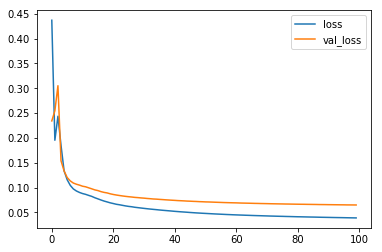

In [55]:
# hidden space = 128
model = linear_autoencoder()
reconstructed_data = model.predict(y_blood_valid)
eval_metrics_linear_ae = mt.rep_metric(y_blood_valid, reconstructed_data)
model.save(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder_linear_128.h5"))

# hidden space = 256
model = linear_autoencoder(code_size=256)
reconstructed_data = model.predict(y_blood_valid)
eval_metrics_linear_ae_256 = mt.rep_metric(y_blood_valid, reconstructed_data)
model.save(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder_linear_256.h5"))

# hidden space = 64
model = linear_autoencoder(code_size=64)
reconstructed_data = model.predict(y_blood_valid)
eval_metrics_linear_ae_256 = mt.rep_metric(y_blood_valid, reconstructed_data)
model.save(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder_linear_64.h5"))

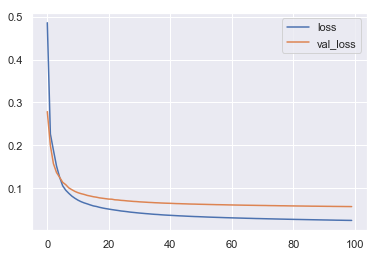

#### Linear Autoencoder - 3 hidden layers

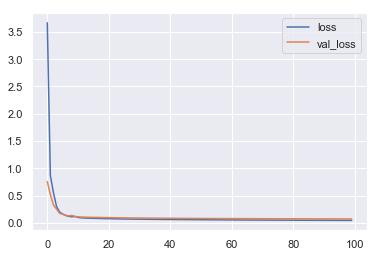

In [113]:
# autoencoder layers size
input_size = y_blood_train.shape[1]
hidden_size = 1024
code_size = 128

# optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.000001,decay=0.01)

# stop condition
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=3),
            plot_losses]

# model
linear_ae = Sequential()
linear_ae.add(Dense(hidden_size, input_shape = (input_size,)))
linear_ae.add(Dense(code_size))
linear_ae.add(Dense(hidden_size))
linear_ae.add(Dense(input_size))
linear_ae.compile(optimizer=adam, loss=mean_squared_error)

linear_ae.fit(y_blood_train, 
              y_blood_train, 
              validation_data=(y_blood_valid, y_blood_valid),
              epochs=100, 
              batch_size=16,
              callbacks=callbacks,
              verbose=0)

reconstructed_data = linear_ae.predict(y_blood_valid)
eval_metrics_linear_ae_hidden_tree = mt.rep_metric(y_blood_valid, reconstructed_data)

In [70]:
linear_ae.save(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder_linear_3xhidden.h5"))

#### 1.1.3 Hidden Layer Autoencoder + non-linear Layer

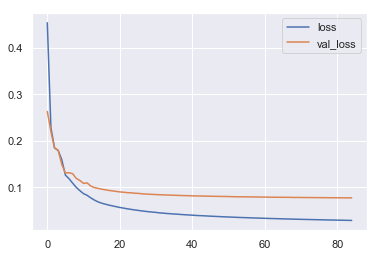

In [114]:
# autoencoder layers size
input_size = y_blood_train.shape[1]
code_size = 128

# optimizer
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.000001,decay=0.01)

# stop condition
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=3),
            plot_losses]

# model
linear_ae = Sequential()
linear_ae.add(Dense(code_size, input_shape = (input_size,), activation='relu'))
linear_ae.add(Dense(input_size))
linear_ae.compile(optimizer=adam, loss=mean_squared_error)

linear_ae.fit(y_blood_train, 
              y_blood_train, 
              validation_data=(y_blood_valid, y_blood_valid),
              epochs=100, 
              batch_size=16,
              callbacks=callbacks,
             verbose=0)
reconstructed_data = linear_ae.predict(y_blood_valid)
eval_metrics_nonlinear_ae = mt.rep_metric(y_blood_valid, reconstructed_data)

linear_ae.save(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder_nonlinear.h5"))

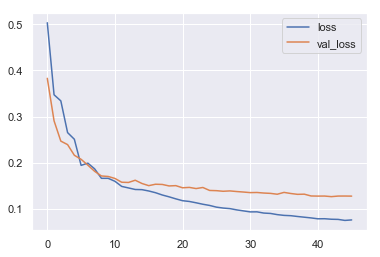

In [120]:
# autoencoder layers size
input_size = y_blood_train.shape[1]
hidden_size = 1024
hidden_size_2 = 512
code_size = 128

# Early stopping after not improving in 3 epochs
callbacks = [
#     ReduceLROnPlateau(monitor='mean_squared_error', patience=3,min_lr=0.001),
    EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=3),
    plot_losses
#   ProgbarLogger(count_mode='steps', stateful_metrics=None)
            ]

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.000001,decay=0.01)

ae = Sequential()
ae.add(Dense(hidden_size, input_shape = (input_size,)))
ae.add(Dense(hidden_size_2, activation='relu'))
ae.add(Dropout(0.1))
ae.add(Dense(hidden_size_2, activation='relu'))
ae.add(Dense(code_size, activation='relu'))
ae.add(Dense(hidden_size_2, activation='relu'))
ae.add(Dense(hidden_size))
ae.add(Dense(input_size))

ae.compile(optimizer=adam, loss=mean_squared_error)

ae.fit(y_blood_train, 
        y_blood_train, 
        validation_data=(y_blood_valid, y_blood_valid),
        epochs=100, 
        batch_size=16,
        callbacks=callbacks,
        verbose=0)

reconstructed_data = ae.predict(y_blood_valid)
eval_metrics = mt.rep_metric(y_blood_valid, reconstructed_data)
autoencoder.save(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder.h5"))

### 2.2 Summary of the models

In [60]:
from keras.models import load_model
from rep import metrics as mt

y_true = y_blood_train
df_summary = pd.DataFrame(columns = ['model','valid_mse_median','valid_pearson_median','valid_pearson_mean','valid_pearson_q25','valid_spearman_median','valid_spearman_mean','valid_spearman_q25'])

models = {'ae':os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder.h5"),
         'pca':eval_metrics_pca,
          'linear_ae_64':os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder_linear_64.h5"),
         'linear_ae_128':os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder_linear_128.h5"),
         'linear_ae_256':os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder_linear_256.h5"),
         'linear_ae 3xhidden':os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder_linear_3xhidden.h5"),
         'non-linear ae':os.path.join(os.readlink(os.path.join("..","..","data")),"processed","models","autoencoder","autoencoder_nonlinear.h5")}

for key in models:
    if key != 'pca':
        model = load_model(models[key])
        y_pred = model.predict(y_true)
        dict_evaluation = mt.rep_metric(y_true, y_pred)
    else:
        dict_evaluation = eval_metrics_pca
    df_summary = df_summary.append({
                       'model': key,
                       'valid_mse_median':dict_evaluation['mse']['median'],
                       'valid_pearson_median':dict_evaluation['pearsonr']['median'],
                       'valid_spearman_median':dict_evaluation['spearmanr']['median'],
                       'valid_mse_mean':dict_evaluation['mse']['mean'],
                       'valid_pearson_mean':dict_evaluation['pearsonr']['mean'],
                       'valid_spearman_mean':dict_evaluation['spearmanr']['mean'],
                       'valid_pearson_q25':dict_evaluation['pearsonr']['p25'],
                       'valid_spearman_q25':dict_evaluation['spearmanr']['p25'],
                      },ignore_index=True)
df_summary      

,model,valid_mse_median,valid_pearson_median,valid_pearson_mean,valid_pearson_q25,valid_spearman_median,valid_spearman_mean,valid_spearman_q25,valid_mse_mean
0,ae,0.097293,0.811408,0.642097,0.399186,0.816692,0.646969,0.415327,0.158906
1,pca,0.005842,0.988117,0.960918,0.962383,0.978195,0.885518,0.850239,0.011275
2,linear_ae_64,0.019576,0.958390,0.853605,0.865501,0.943896,0.793471,0.712255,0.038700
3,linear_ae_128,0.014502,0.968899,0.867455,0.894213,0.955875,0.803176,0.736085,0.028396
4,linear_ae_256,0.013235,0.971957,0.864607,0.899612,0.959811,0.800417,0.730212,0.024756
5,linear_ae 3xhidden,0.053480,0.878240,0.725069,0.626410,0.872416,0.691806,0.485851,0.098722
6,non-linear ae,0.013613,0.970770,0.875809,0.905025,0.956422,0.805889,0.728853,0.028221


### Blood autoencoder analysis

In [123]:
y_pred_train = autoencoder.predict(y_blood_train)
y_pred_valid = autoencoder.predict(y_blood_valid)

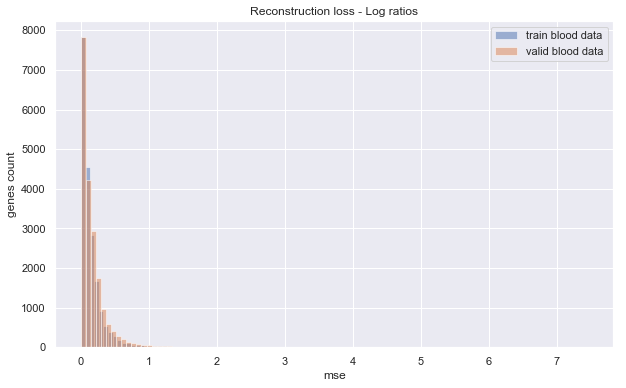

In [124]:
mse_train=metrics.mean_squared_error(y_blood_train, y_pred_train, multioutput='raw_values')
mse_valid=metrics.mean_squared_error(y_blood_valid, y_pred_valid, multioutput='raw_values')

sns.set()
f, ax = plt.subplots(1, 1)

ax.hist(mse_train,bins=100, label = 'train blood data', alpha = 0.5)
plt.title("Reconstruction loss - Log ratios")
plt.xlabel("mse")
plt.ylabel("genes count")
fig = plt.gcf()
fig.set_size_inches(10, 6)

ax.hist(mse_valid,bins=100, label = 'valid blood data', alpha = 0.5)
ax.legend()
plt.show()

In [125]:
abs_error_train=np.mean(np.absolute(y_blood_train - y_pred_train), axis=0)
abs_error_valid=np.mean(np.absolute(y_blood_valid - y_pred_valid), axis=0)

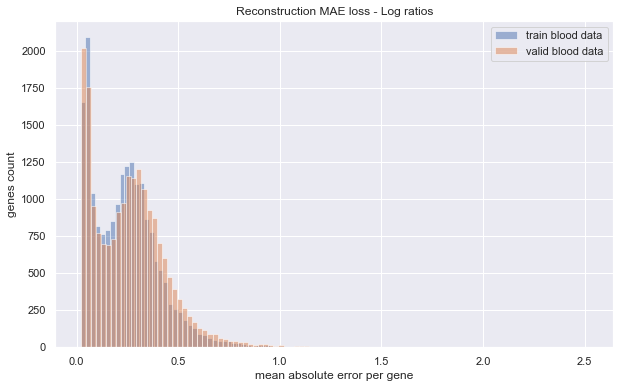

In [126]:
sns.set()
f, ax = plt.subplots(1, 1)

ax.hist(abs_error_train,bins=100, label = 'train blood data', alpha = 0.5)
plt.title("Reconstruction MAE loss - Log ratios")
plt.xlabel("mean absolute error per gene")
plt.ylabel("genes count")
fig = plt.gcf()
fig.set_size_inches(10, 6)

ax.hist(abs_error_valid,bins=100, label = 'valid blood data', alpha = 0.5)
ax.legend()
plt.show()

## Run for all tissues the dimensionality reduction using the autoencoder model

In [21]:
import rep.preprocessing_new as prep
import rep.datasets as d
import rep.models as m
import warnings; warnings.simplefilter('ignore')

import pandas as pd

In [37]:
# load train valida data
path = "/s/project/rep/"

features_file = path + "processed/gtex/recount/recount_gtex_norm_tmp.h5ad"
# features_file = path + "processed/gtex/recount/recount_gtex_logratios.h5ad"
train_individuals_file = path + "processed/gtex/recount/train_individuals.txt"
train_individuals = prep.read_csv_one_column(train_individuals_file)

valid_individuals_file = path + "processed/gtex/recount/valid_individuals.txt"
valid_individuals = prep.read_csv_one_column(valid_individuals_file)

gtex = prep.RepAnnData.read_h5ad(features_file)
gtex_filtered_valid = gtex[gtex.samples['Individual'].isin(valid_individuals)]
gtex_filtered_train = gtex[gtex.samples['Individual'].isin(train_individuals)]
del gtex

In [23]:
x_train = gtex_filtered_train.X
x_valid = gtex_filtered_valid.X

scaler_train = preprocessing.MinMaxScaler()
x_train_norm = scaler_train.fit_transform(x_train)
scaler_valid = preprocessing.MinMaxScaler()
x_valid_norm = scaler_train.fit_transform(x_valid)


autoencoder.reset_states()
autoencoder.fit(x_train_norm, 
                x_train_norm,
                validation_data=(x_valid_norm, x_valid_norm),
                epochs=100, 
                batch_size=256,
                validation_split=0.33,
                callbacks=callbacks)

Train on 5389 samples, validate on 1820 samples
Epoch 1/100
5389/5389 [==============================] - 18s 3ms/step - loss: 0.0169 - val_loss: 0.0170
Epoch 2/100
5389/5389 [==============================] - 19s 4ms/step - loss: 0.0130 - val_loss: 0.0148
Epoch 3/100
5389/5389 [==============================] - 17s 3ms/step - loss: 0.0114 - val_loss: 0.0144
Epoch 4/100
5389/5389 [==============================] - 18s 3ms/step - loss: 0.0110 - val_loss: 0.0142
Epoch 5/100
5389/5389 [==============================] - 18s 3ms/step - loss: 0.0108 - val_loss: 0.0140


In [43]:
tissues = gtex_filtered_valid.obs['Parent_Tissue'].drop_duplicates().tolist()

# encoded data
encoder.reset_states()
encoder.layers[0].set_weights(autoencoder.layers[1].get_weights())
encoder.layers[1].set_weights(autoencoder.layers[2].get_weights())
encoder.layers[2].set_weights(autoencoder.layers[3].get_weights())

encoded_data = encoder.predict(x_valid_norm)
recovered_data = autoencoder.predict(x_valid_norm)

In [44]:
encoded_data.shape, recovered_data.shape

((1820, 256), (1820, 19932))

scanpy==1.3.7 anndata==0.6.16 numpy==1.15.0 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


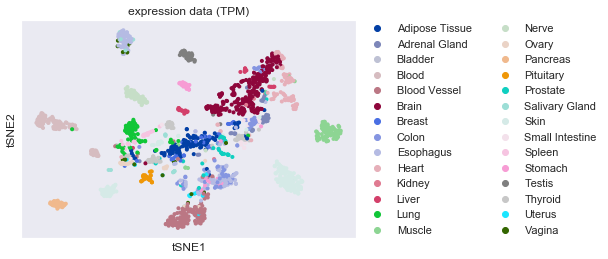

In [45]:
import scanpy.api as sc
sc.logging.print_versions()

sc.tl.tsne(gtex_filtered_valid,copy=False)
sc.pl.tsne(gtex_filtered_valid, color="Parent_Tissue", title='expression data (TPM)')

         Falling back to preprocessing with `sc.pp.pca` and default params.


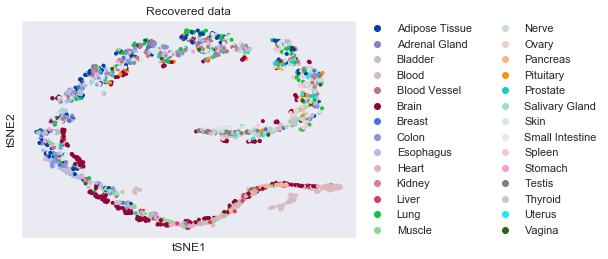

In [47]:
from anndata import AnnData
anndata_obj = AnnData(X=recovered_data)
anndata_obj.obs = gtex_filtered_valid.obs
sc.tl.tsne(anndata_obj)
sc.pl.tsne(anndata_obj, title='Recovered data', color="Parent_Tissue")

         Falling back to preprocessing with `sc.pp.pca` and default params.


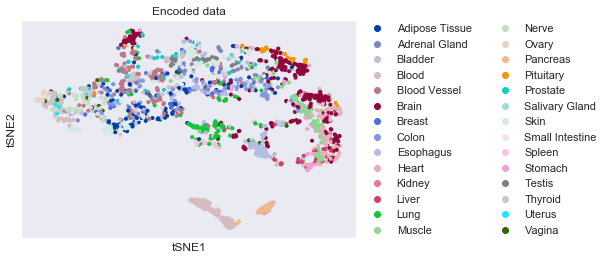

In [42]:
from anndata import AnnData
anndata_obj = AnnData(X=encoded_data)
anndata_obj.obs = gtex_filtered_valid.obs
sc.tl.tsne(anndata_obj)
sc.pl.tsne(anndata_obj, title='Encoded data', color="Parent_Tissue")

In [32]:
pca = decomposition.PCA(n_components=256)
pca.fit(x_valid_norm)
pca_transformed = pca.transform(x_valid_norm)

data = pd.DataFrame({
                     'C1':pca_transformed[:,0].flatten(), 
                     'C2':pca_transformed[:,1].flatten(),
                     'tissue':gtex_filtered_valid.obs['Parent_Tissue'].tolist(),
                     'dim_reduction':'PCA'})

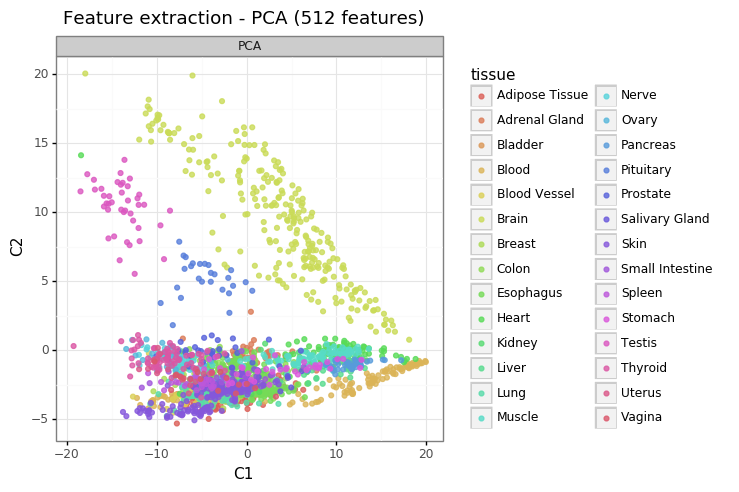

<ggplot: (8730074108757)>

In [33]:
fig = (
        ggplot(data, aes(x='C1', y='C2',color='tissue')) + 
        geom_point(alpha=0.8) + 
        theme_bw() + 
        facet_wrap('~dim_reduction', ncol = 2) + 
            theme(figure_size = (5, 5)) + 
        ggtitle('Feature extraction - PCA (512 features)'))
fig